# NeuroCluster:
<font size= 4> Non-parametric cluster-based permutation testing to identify neurophysiological encoding of continuous variables with time-frequency resolution

Authors: Christina Maher & Alexandra Fink-Skular \
Updated: 07/17/2024 by AFS

In [1]:
import numpy as np
import pandas as pd
import mne
from glob import glob
from scipy.stats import zscore, t, linregress, ttest_ind, ttest_rel, ttest_1samp 
import os 
import re
import h5io
import pickle 
import time 
import datetime 
from joblib import Parallel, delayed
import statsmodels.api as sm 
from scipy.ndimage import label 
import statsmodels.formula.api as smf
from tqdm import tqdm
import operator
import matplotlib.pyplot as plt
import inspect


import warnings
warnings.filterwarnings('ignore')

# keep this so we can use our respective paths for testing
current_user = 'alie'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
date = datetime.date.today().strftime('%m%d%Y')
print(date)

07162024


In [4]:
if current_user == 'christina':
    base_dir = '/Users/christinamaher/Documents/GitHub/NeuroCluster/scripts/'
    data_dir = '/Users/christinamaher/Documents/GitHub/NeuroCluster/'
    tfr_dir  = f'{data_dir}tfr/'
    anat_dir = f'{data_dir}anat/'
elif current_user == 'alie':
    # base_dir = '/hpc/users/finka03/NeuroCluster/NeuroCluster/'
    # swb_dir  = '/sc/arion/projects/guLab/Alie/SWB/'
    # tfr_dir  = f'{swb_dir}ephys_analysis/data/'
    # beh_dir  = f'{swb_dir}swb_behav_models/data/behavior_preprocessed/'
    # anat_dir = f'{swb_dir}ephys_analysis/recon_labels/'
    # save_dir = f'{base_dir}/data/'
    
    base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/NeuroCluster/NeuroCluster/NeuroCluster/scripts/'
    data_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
    tfr_dir  = f'{data_dir}ephys_analysis/data/'
    beh_dir  = f'{data_dir}behavior_analysis/behavior_preprocessed/'
    anat_dir = f'{data_dir}anat_recons/'

In [5]:
# load functions 
import sys
sys.path.append(f'{base_dir}')
# sys.path.append(f'{base_dir}scripts/')

from tfr_cluster_test import *
from helper_utils import *
# from plotting_utils import * 

# Step 1: Format Input Data (Currently within-subject)
- neural input: np.array (n_channels x n_epochs x n_freqs x n_times)
- regressor data: np.array (numpy array: n_epochs x n_features)

In [6]:
# load epoched data for single subj
if current_user == 'alie':
    permute_var = 'decisionCPE'
    subj_id     = 'MS002'   
    power_epochs = mne.time_frequency.read_tfrs(fname=f'{tfr_dir}{subj_id}/{subj_id}_CpeOnset-tfr.h5')[0]
elif current_user == 'christina':
    permute_var = 'ev_zscore'
    subj_id     = 'MS009'   
    power_epochs = mne.time_frequency.read_tfrs(fname=f'{tfr_dir}/{subj_id}_tfr.h5')[0]

Reading /Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/MS002/MS002_CpeOnset-tfr.h5 ...
Adding metadata with 19 columns


In [7]:
# set ROI for single ROI anaylsis 
if current_user == 'alie':
#     roi = 'ains'
    # set all variables included mutliple regression 
    multi_reg_vars = ['GambleChoice','TrialEV','decisionCPE']
    # set main variable of interest for permutations 
    permute_var = 'decisionCPE'
    # load subj behavior data 
#     beh_df = pd.read_csv(f'{beh_dir}{subj_id}_task_data')
    beh_df = power_epochs.metadata.copy()
    # beh_df['subj_id'] = subj_id
    # add TrialEV to df
    beh_df['TrialEV'] = beh_df.GambleEV - beh_df.SafeBet
    # clean subj dataframe from fail trials/nan values in vars of interest     
    # beh_df = beh_df[(beh_df.GambleChoice=='gamble')|(beh_df.GambleChoice=='safe')]
#     beh_df = beh_df[(beh_df.Outcome=='good')|(beh_df.Outcome=='bad')]
    
    # zscore continuous variables 
    beh_df[multi_reg_vars[1:]] = pd.DataFrame({f'{var}':zscore(beh_df[var])  for var in multi_reg_vars[1:]})
    # format final beh_df
    beh_df = beh_df[multi_reg_vars].reset_index(drop=True) 
    # convert choice to categorical variable
    beh_df['GambleChoice'] = beh_df['GambleChoice'].astype('category')

elif current_user == 'christina':
    beh_df = prepare_regressor_df(power_epochs)
    ## new function for getting elecs in ROI
    roi = ['lpfc','ofc']
    roi_subj_elecs = prepare_anat_dic(roi, f'{anat_dir}master_labels.csv')
    roi_subj_elecs


In [8]:
multi_reg_vars

['GambleChoice', 'TrialEV', 'decisionCPE']

In [9]:
#### class TFR_Cluster_Test dev + debugging

if current_user == 'alie':

    # subset single electrode tfr data + behav data
    dev_ch_idx     = power_epochs.ch_names.index('laims2-laims3')
    ch_name        = 'laims2-laims3'
    tfr_data       = np.squeeze(power_epochs._data[:,dev_ch_idx,:,:].copy())
    predictor_data = beh_df.copy()
    
    # predictor_data = predictor_data.drop(columns='subj_id')

elif current_user == 'christina':
    
        # subset single electrode tfr data + behav data
        # predictor_data = predictor_data.drop(columns=['condition','chosen_shape_current_trial','chosen_color_current_trial','chosen_shape_previous_trial','chosen_color_previous_trial','ev'])
        tfr_data = np.squeeze(power_epochs._data[:,0,:,:].copy())
        ch_name = power_epochs.info['ch_names'][0]

## Step 2: Find Real Clusters
- Use TFRClusterTest class code to run multivariate regression
- Allows for multiple regression implementation and pixel paralellization, so with more speed improvements will ultimately be worth it.

In [10]:
predictor_data

,GambleChoice,TrialEV,decisionCPE
0,safe,-0.871214,-0.800927
1,gamble,-0.551785,-0.899141
2,gamble,1.630983,1.470249
3,safe,0.779171,0.880971
4,gamble,0.495234,0.807311
...,...,...,...
145,gamble,-0.356578,0.512672
146,safe,-0.179117,-0.297586
147,gamble,-0.640515,-1.206056
148,gamble,0.495234,-0.469458


In [11]:
cluster_test  = TFR_Cluster_Test(tfr_data,predictor_data,permute_var,ch_name,alternative='two-sided')
cluster_test

In [12]:
betas, tstats = cluster_test.tfr_regression()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 42576 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 45030 out of 45030 | elapsed:    7.0s finished


In [13]:
tstats

array([[ 0.62723178,  0.61911294,  0.61088622, ..., -0.09695997,
        -0.10242376, -0.10794783],
       [ 0.44771582,  0.44300545,  0.43819625, ..., -0.27711809,
        -0.27369909, -0.2703095 ],
       [ 0.43490104,  0.43932054,  0.44367209, ..., -0.45004675,
        -0.43404994, -0.41794274],
       ...,
       [-0.41708621, -0.511743  , -0.53946964, ..., -0.37382552,
        -0.30060442, -0.26340763],
       [-0.21300067, -0.76956835, -1.30797729, ..., -0.46665564,
        -0.56813713, -0.72451961],
       [ 0.88503558,  0.75467834,  0.6200775 , ..., -0.74351604,
        -0.39777248, -0.12702793]])

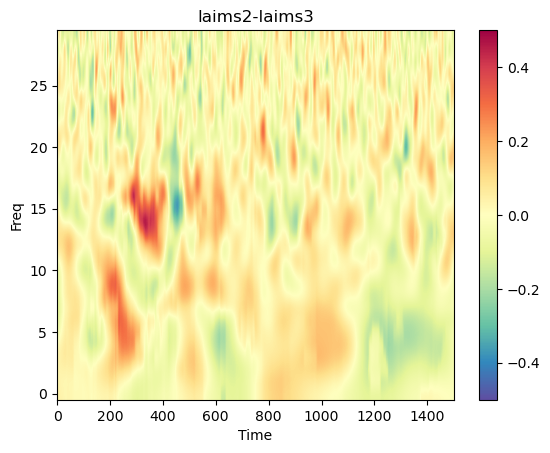

In [14]:
plt.imshow(betas, interpolation = 'Bicubic',cmap='Spectral_r', aspect='auto',origin='lower',vmin=-.5,vmax=.5) 
plt.colorbar()
plt.ylabel('Freq')
plt.xlabel('Time')
plt.title(f'{power_epochs.ch_names[16]}')
plt.show()

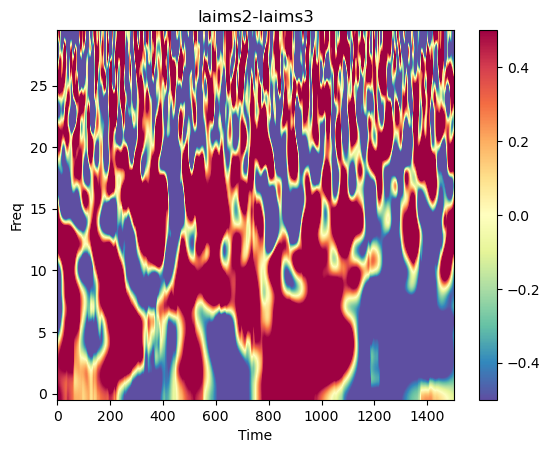

In [15]:
plt.imshow(tstats, interpolation = 'Bicubic',cmap='Spectral_r', aspect='auto',origin='lower',vmin=-.5,vmax=.5) 
plt.colorbar()
plt.ylabel('Freq')
plt.xlabel('Time')
plt.title(f'{power_epochs.ch_names[16]}')
plt.show()

In [16]:
max_cluster_data  = cluster_test.max_tfr_cluster(tstats,output='all')


In [17]:
max_cluster_data

[{'cluster_stat': 827.9530005654042,
  'freq_idx': (11, 19),
  'time_idx': (276, 396)},
 {'cluster_stat': -157.92421436694954,
  'freq_idx': (15, 16),
  'time_idx': (437, 471)}]

## Step 3: Compute Null Cluster Distribution from Permutations

In [502]:
# cluster_test  = TFR_Cluster_Test(tfr_data,predictor_data,permute_var,ch_name,alternative='two-sided')
# cluster_test

In [465]:
cluster_test.permuted_tfr_regression()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 6384 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 32368 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 45030 out of 45030 | elapsed:    7.7s finished


array([[ 1.21946117,  1.05274657, -0.59118267, ..., -0.00224675,
         0.04793529, -1.30984727],
       [-0.93287133, -1.2538617 , -1.33073957, ..., -0.63478631,
         0.46958635, -0.06323564],
       [-1.45550503,  0.92795241,  0.19723604, ..., -1.72029963,
        -0.23949273, -1.4468783 ],
       ...,
       [-0.84880567,  0.13709506,  0.39030849, ..., -0.41612269,
        -1.12576087, -0.18230251],
       [ 1.21914532, -0.06849403,  0.73331996, ...,  0.20209963,
        -0.59611533, -1.31644373],
       [ 0.90746496,  0.7100644 ,  1.18321756, ...,  0.52961922,
        -0.40180228, -0.31800286]])

In [18]:
n_permutations = 10

In [19]:
gen_tstats = (cluster_test.permuted_tfr_regression() for _ in range(n_permutations))

In [20]:
gen_tstats

<generator object <genexpr> at 0x7f9308661000>

In [21]:
test_null = []
for gen in gen_tstats:
    perm_max = cluster_test.max_tfr_cluster(gen,output='cluster_stat')
    test_null.append(perm_max)

In [22]:
test_null

[[{'cluster_stat': 8.16834157935428}, {'cluster_stat': -12.320558464168293}],
 [{'cluster_stat': 7.1106368239391795}, {'cluster_stat': -10.23613085438794}],
 [{'cluster_stat': 8.886490612786128}, {'cluster_stat': -12.443863211992989}],
 [{'cluster_stat': 9.270804072542536}, {'cluster_stat': -11.460748180286991}],
 [{'cluster_stat': 8.060546152091606}, {'cluster_stat': -9.28344846077028}],
 [{'cluster_stat': 8.494687380659332}, {'cluster_stat': -9.674427499613262}],
 [{'cluster_stat': 10.091768348652977}, {'cluster_stat': -9.227067094793641}],
 [{'cluster_stat': 8.660055577937161}, {'cluster_stat': -8.48492528123911}],
 [{'cluster_stat': 7.202378655135886}, {'cluster_stat': -13.849652384866715}],
 [{'cluster_stat': 10.672606357767943}, {'cluster_stat': -10.994073033918326}]]

In [491]:
test_null = []
for gen in tqdm(gen_tstats,total=n_permutations):
    perm_max = cluster_test.max_tfr_cluster(gen,output='cluster_stat')
    test_null.append(perm_max)

100%|██████████| 10/10 [01:14<00:00,  7.41s/it]


In [ ]:

# from tqdm import tqdm
 
 
# for i in tqdm(range(0, 100), disable = True,
#                desc ="Text You Want"):
#     sleep(.1)
 
# print("Iteration Successful")

#### POLISHED WORKFLOW

In [ ]:
### NeuroCluster single electrode workflow: 

# Step 1: Create TFR_Cluster_Test Object
cluster_test  = TFR_Cluster_Test(tfr_data,predictor_data,permute_var,ch_name,alternative='two-sided')

# Step 2: Run TFR regression to extract beta coefficients for predictor of interest (permute_var) & tstats for each pixel in TFR
betas, tstats = cluster_test.tfr_regression()

# Step 3: Find largest cluster(s) and return the max cluster statistic(s) and cluster's  frequencies x times indices
max_cluster_data  = cluster_test.max_tfr_cluster(tstats,output='all')

# Step 4: Create null distribution of maximum cluster statistics from permuted data
null_cluster_distribution = cluster_test.compute_null_cluster_stats(max_cluster_data,num_permutations=10)

# Step 5: Use null cluster statistic distribution from permutations to compute non-parametric p value 
cluster_pvalue = cluster_test.cluster_significance_test(max_cluster_data,null_cluster_distribution,alpha=0.05) #compute_cluster_pvalue cluster_significance_test



### ignore here

In [ ]:
# start = time.time() # start timer

# ## run simple linear regression on electrodes in parallel to speed up computation - I did this for just the subset OFC electrodes.
# subj_all_elec_data = Parallel(n_jobs=-1,verbose=5)(
#     delayed(TFR_Cluster_Test.tfr_cluster_results())(
#         np.squeeze(power_epochs._data[:,ch_ix,:,:].copy()),predictor_data,permute_var,ch_name
#         ) for ch_ix, ch_name in enumerate(power_epochs.ch_names))

# end = time.time()    
# print('{:.4f} s'.format(end-start)) # print time elapsed for computation (approx 20 seconds per channel)

# # save subj cluster data for all electrodes
# pickle.dump(subj_all_elec_data, open(f'{save_dir}{subj_id}_all_elec_real_clusters.pkl', "wb")) 



In [ ]:
# To implement FDR correction: 
# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
# multitest.multipletests(p_upper, method='fdr_bh')